In [19]:
import pandas as pd

In [29]:
# Resolve notebook directory and choose train file
from pathlib import Path
nb_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
# train_data_path = 'data/countdown/train.parquet'
# train_data_path = 'data/arc/train.parquet'
# train_data_path = 'data/zebra/train.parquet'
# train_data_path = 'data/combined/train_arc.parquet'
# train_data_path = 'data/combined/train_countdown.parquet'
train_data_path = nb_dir / 'data' / 'combined' / 'train_countdown.parquet'

try:
    df_train = pd.read_parquet(train_data_path)
    display(df_train.head())
except Exception as e:
    print('Error reading parquet:', type(e).__name__, e)
    print('Checked path:', train_data_path)


,data_source,prompt,ability,reward_model,extra_info
0,countdown-easy-train,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'numbers': '5,17,91', 'targe...","{'difficulty': 1, 'index': 0, 'question': 'Usi..."
1,countdown-easy-train,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'numbers': '11,24,18', 'targ...","{'difficulty': 1, 'index': 1, 'question': 'Usi..."
2,countdown-easy-train,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'numbers': '91,47,73', 'targ...","{'difficulty': 1, 'index': 2, 'question': 'Usi..."
3,countdown-easy-train,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'numbers': '19,35,99', 'targ...","{'difficulty': 1, 'index': 3, 'question': 'Usi..."
4,countdown-easy-train,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'numbers': '69,37,1', 'targe...","{'difficulty': 1, 'index': 4, 'question': 'Usi..."


In [30]:
# train split size
len(df_train)

30000

In [ ]:
sample = df_train.iloc[0]
print('prompt:\t', sample['prompt'])
print('reward_model:\t', sample['reward_model'])
print('extra_info', sample['extra_info'])


prompt:	 [{'content': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.\nUser: Using the numbers [19, 75, 83], create an equation that equals 177. You can only use basic arithmetic operations (+, -, *, /) and each number should be used exactly once. Return the final answer in \\boxed{}, for example \\boxed{(1 + 2) / 3}.\nAssistant: Let me solve this step by step.', 'role': 'user'}]
reward_model:	 {'ground_truth': {'numbers': '19,75,83', 'target': 177}, 'style': 'rule'}
extra_info {'difficulty': 1, 'index': 5040, 'question': 'Using the numbers 19, 75, 83 and basic arithmetic operations (+, -, *, /), create an expression that equals 177.\nYou need to use each number exactly once.\nPresent the final expression that equals the target number within \\boxed{}. For example: \\boxed{46+68/(52-50)}\n', 'split': 'train', 'type': 'countdow

In [32]:
test_data_path = 'data/combined/test_zebra.parquet'

df_test = pd.read_parquet(test_data_path)
df_test.head()

,data_source,prompt,ability,reward_model,extra_info
0,zebra-easy-test,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'target': 'alice'}, 'style':...","{'difficulty': 1, 'index': 0, 'question': 'Thi..."
1,zebra-easy-test,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'target': 'alice'}, 'style':...","{'difficulty': 1, 'index': 1, 'question': 'Thi..."
2,zebra-easy-test,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'target': 'arnold'}, 'style'...","{'difficulty': 1, 'index': 2, 'question': 'Thi..."
3,zebra-easy-test,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'target': 'bob'}, 'style': '...","{'difficulty': 1, 'index': 3, 'question': 'Thi..."
4,zebra-easy-test,[{'content': 'A conversation between User and ...,math,"{'ground_truth': {'target': 'alice'}, 'style':...","{'difficulty': 1, 'index': 4, 'question': 'Thi..."


In [33]:
# test split size
len(df_test)

800

Loading arc /Users/raziq/Documents/University of Maryland/CMSC 848N/cofa/sec/data/combined/train_arc.parquet
Loading countdown /Users/raziq/Documents/University of Maryland/CMSC 848N/cofa/sec/data/combined/train_countdown.parquet
Loading zebra /Users/raziq/Documents/University of Maryland/CMSC 848N/cofa/sec/data/combined/train_zebra.parquet
No difficulty values outside {1,2,3} found.


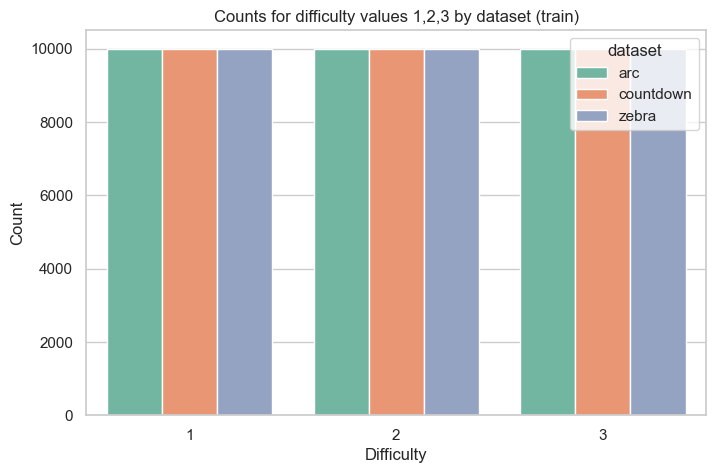

Saved bar plot to /Users/raziq/Documents/University of Maryland/CMSC 848N/cofa/sec/SEC_human_annotated_difficulties.png


In [27]:
# Plot simple bars for difficulty values 1, 2, 3 across the three train datasets.
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

base = Path.cwd() / 'data' / 'combined'
files = {
    'arc': base / 'train_arc.parquet',
    'countdown': base / 'train_countdown.parquet',
    'zebra': base / 'train_zebra.parquet'
}

COLS = [1, 2, 3]
rows = []
anomalies = {}

for name, path in files.items():
    print('Loading', name, path)
    df = pd.read_parquet(path)

    def extract_diff(ei):
        if isinstance(ei, dict):
            return ei.get('difficulty')
        try:
            if hasattr(ei, 'get'):
                return ei.get('difficulty')
        except Exception:
            pass
        if isinstance(ei, str):
            try:
                parsed = ast.literal_eval(ei)
                if isinstance(parsed, dict):
                    return parsed.get('difficulty')
            except Exception:
                return None
        return None

    diffs = pd.to_numeric(df['extra_info'].apply(extract_diff), errors='coerce')
    diffs = diffs.dropna().astype(int)

    # counts for 1,2,3
    counts = diffs.value_counts().to_dict()
    for d in COLS:
        rows.append({'dataset': name, 'difficulty': int(d), 'count': int(counts.get(d, 0))})

    # detect values outside expected range
    outside = sorted([k for k in counts.keys() if k not in COLS])
    if outside:
        anomalies[name] = {k: counts[k] for k in outside}

# report anomalies if any
if anomalies:
    print('Found difficulty values outside {1,2,3}:')
    for ds, vals in anomalies.items():
        print(f" - {ds}: {vals}")
else:
    print('No difficulty values outside {1,2,3} found.')

plot_df = pd.DataFrame(rows)

plt.figure(figsize=(8,5))
sns.set_theme(style='whitegrid')
# grouped bar plot: x=difficulty, hue=dataset
sns.barplot(x='difficulty', y='count', hue='dataset', data=plot_df, palette='Set2')
plt.title('Counts for difficulty values 1,2,3 by dataset (train)')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.xticks([0,1,2], [1,2,3])

out_path = Path.cwd() / 'SEC_human_annotated_difficulties.png'
plt.savefig(out_path, dpi=200, bbox_inches='tight')
plt.show()
print('Saved bar plot to', out_path)


In [28]:
# Compute counts per difficulty (1,2,3) and export CSV
import pandas as pd
from pathlib import Path
import ast

base = Path.cwd() / 'data' / 'combined'
files = {
    'arc': base / 'train_arc.parquet',
    'countdown': base / 'train_countdown.parquet',
    'zebra': base / 'train_zebra.parquet'
}

COLS = [1,2,3]
rows = []

for name, path in files.items():
    df = pd.read_parquet(path)
    def _get(ei):
        if isinstance(ei, dict):
            return ei.get('difficulty')
        try:
            if hasattr(ei, 'get'):
                return ei.get('difficulty')
        except Exception:
            pass
        if isinstance(ei, str):
            try:
                parsed = ast.literal_eval(ei)
                if isinstance(parsed, dict):
                    return parsed.get('difficulty')
            except Exception:
                return None
        return None

    diffs = pd.to_numeric(df['extra_info'].apply(_get), errors='coerce')
    diffs = diffs.dropna().astype(int)
    counts = diffs.value_counts().to_dict()
    row = {'dataset': name}
    for d in COLS:
        row[f'difficulty_{d}'] = int(counts.get(d, 0))
    # also include a column for anomalies if any
    outside = sum(v for k,v in counts.items() if k not in COLS)
    row['difficulty_outside_1_3'] = int(outside)
    rows.append(row)

summary_df = pd.DataFrame(rows)
out_csv = Path.cwd() / 'SEC_difficulty_summary.csv'
summary_df.to_csv(out_csv, index=False)
print('Saved difficulty counts CSV to', out_csv)
summary_df


Saved difficulty counts CSV to /Users/raziq/Documents/University of Maryland/CMSC 848N/cofa/sec/SEC_difficulty_summary.csv


,dataset,difficulty_1,difficulty_2,difficulty_3,difficulty_outside_1_3
0,arc,10000,10000,10000,0
1,countdown,10000,10000,10000,0
2,zebra,10000,10000,10000,0
